Calculated Threshold for Primes +1: 27401.5


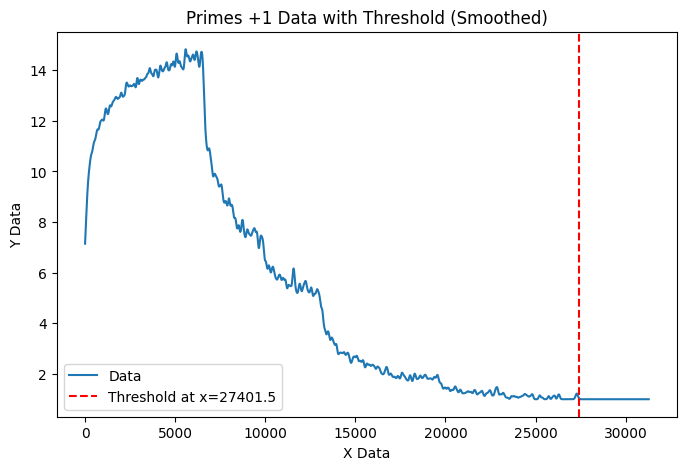

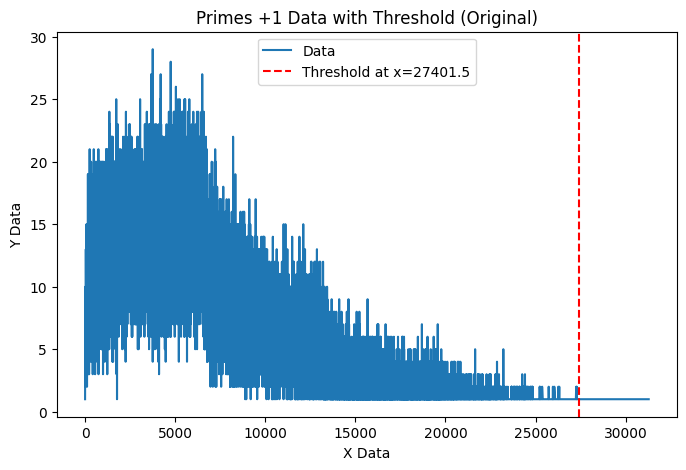

Calculated Threshold for Primes -1: 26108.5


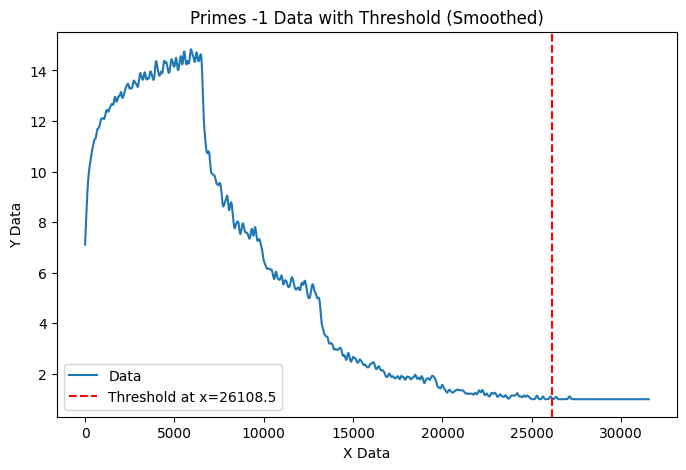

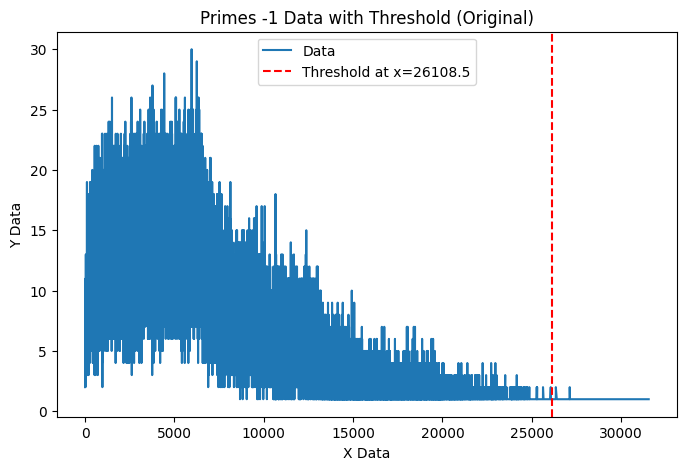

Calculated Threshold for Twins: 399.5


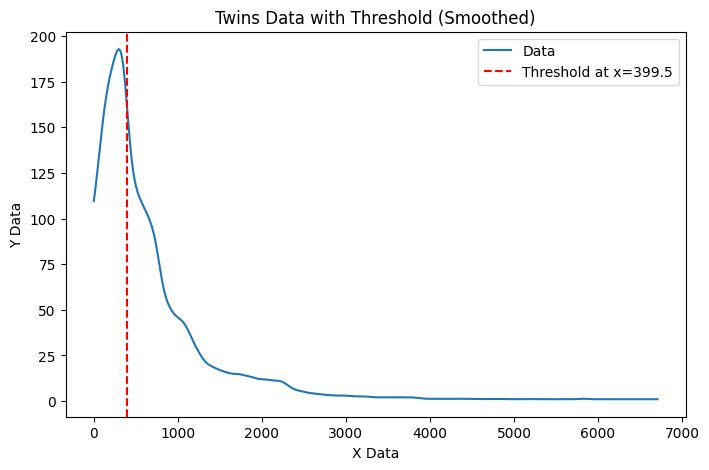

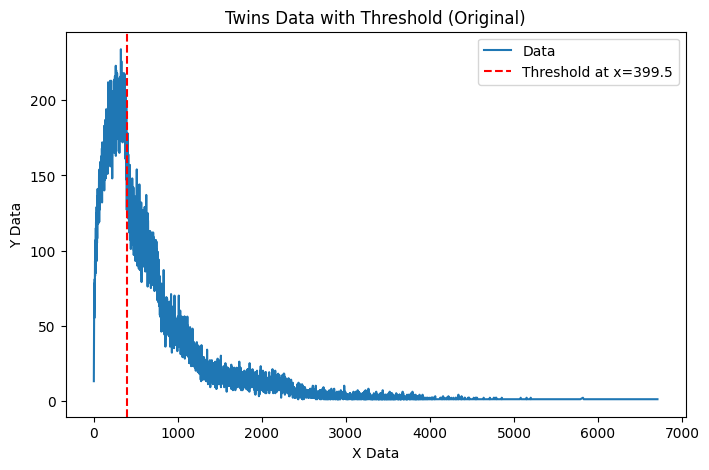

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def kernel_smooth_data(x_data, y_data, bandwidth):
    """
    Apply kernel smoothing to the data using a Gaussian kernel.
    
    Parameters:
        x_data (np.array): The independent variable values.
        y_data (np.array): The dependent variable values.
        bandwidth (float): The smoothing bandwidth controlling the kernel width.
                           A larger bandwidth produces a smoother curve.
    
    Returns:
        tuple: (x_data, smoothed_y) where smoothed_y is the kernel-smoothed estimate.
    
    Methodology:
        For each point x in x_data, compute the weighted average of all y values using 
        weights defined by the Gaussian kernel:
        
            w(x, x_j) = exp(-0.5 * ((x_j - x) / bandwidth)^2)
    """
    smoothed_y = np.empty_like(y_data, dtype=float)
    
    for i, x in enumerate(x_data):
        # Calculate Gaussian kernel weights for all points relative to x
        weights = np.exp(-0.5 * ((x_data - x) / bandwidth) ** 2)
        # Compute the weighted average
        smoothed_y[i] = np.sum(weights * y_data) / np.sum(weights)
    
    return x_data, smoothed_y

def find_threshold(x_data, y_data):
    """
    Identify the threshold as the x-value corresponding to the most significant drop 
    between two consecutive points in the smoothed data.
    
    The drop between two points is defined as the difference:
    
        drop = y[i] - y[i+1]
    
    We select the pair of points with the maximum drop and set the threshold as the 
    midpoint between the corresponding x-values.
    
    Returns:
        float: The threshold x-value computed as (x[i] + x[i+1]) / 2,
               where the drop y[i] - y[i+1] is maximized.
    """
    # Compute differences between consecutive y-values
    differences = np.diff(y_data)
    # Find the index where the drop is the largest (i.e., most negative difference)
    index = np.argmin(differences)
    # Use the midpoint between the two corresponding x values as the threshold
    threshold = (x_data[index] + x_data[index + 1]) / 2
    return threshold

def plot_data_with_threshold(x_data, y_data, threshold, title):
    """
    Plot the data and mark the threshold with a vertical line.
    
    Parameters:
        x_data (np.array): The x-values for the plot.
        y_data (np.array): The y-values for the plot.
        threshold (float): The x-value where the threshold is detected.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(x_data, y_data, label="Data")
    plt.axvline(x=threshold, color='red', linestyle='--', 
                label=f"Threshold at x={threshold}")
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title(title)
    plt.legend()
    plt.show()

# ---------------------------
# Main Script Implementation
# ---------------------------

# Load data (ensure that 'primes_data_150000.txt' is available in your working directory)
datatxt_all = pd.read_csv('primes_data_150000.txt', low_memory=False)

# Define the kernel bandwidth for smoothing.
# Adjust this value based on the scale and noise level of your data.
bandwidth = 50  

# Process each specified column
for column in ['Primes +1', 'Primes -1', 'Twins']:
    # Get counts for each unique value and sort them to form x_data
    data_counts = datatxt_all[column].value_counts().sort_index()
    x_data = data_counts.index.to_numpy()
    y_data = data_counts.values
    
    # Apply kernel smoothing
    smoothed_x, smoothed_y = kernel_smooth_data(x_data, y_data, bandwidth)
    
    # Identify the threshold as the mid-point between the two points with the largest drop
    threshold = find_threshold(smoothed_x, smoothed_y)
    print(f"Calculated Threshold for {column}: {threshold}")
    
    # Plot the smoothed data with the threshold
    plot_data_with_threshold(smoothed_x, smoothed_y, threshold,
                             f"{column} Data with Threshold (Smoothed)")
    
    # Optionally, plot the original data with the same threshold for comparison
    plot_data_with_threshold(x_data, y_data, threshold,
                             f"{column} Data with Threshold (Original)")


Best sigma for Primes +1: 20, Calculated Threshold: 868


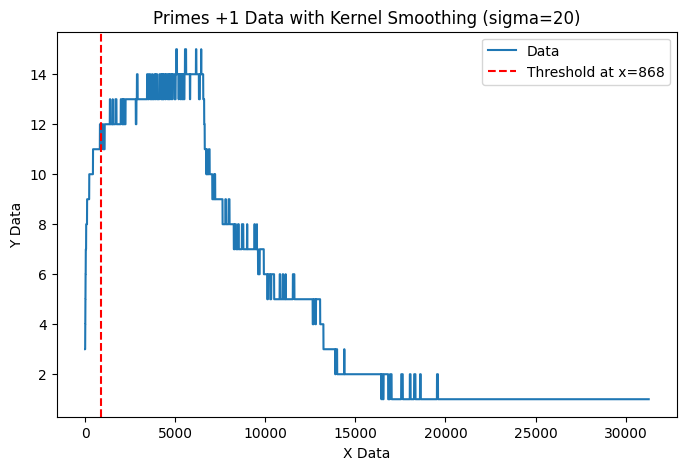

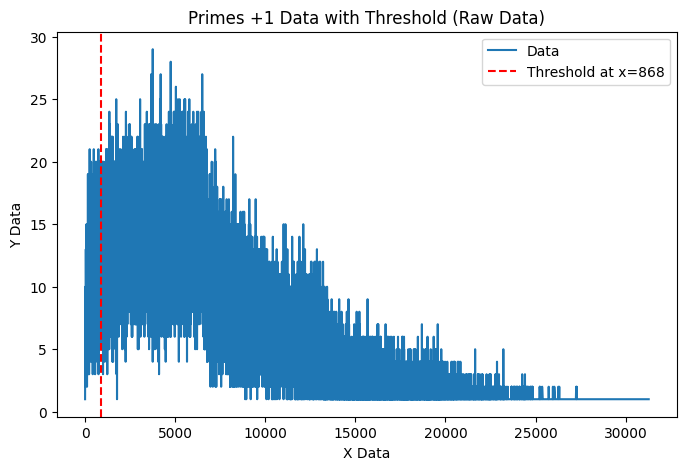

Best sigma for Primes -1: 12, Calculated Threshold: 425


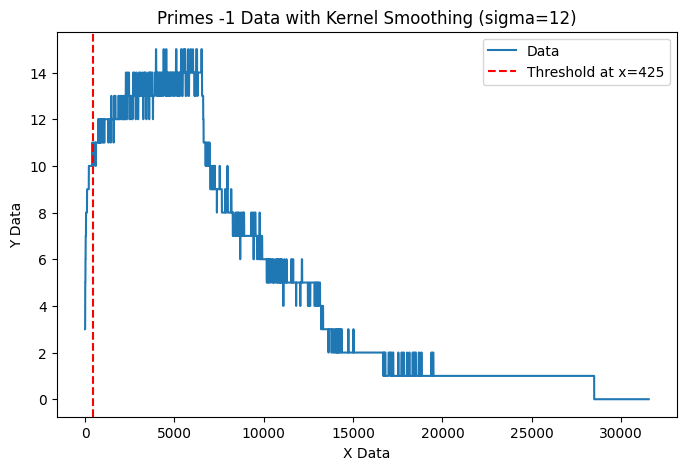

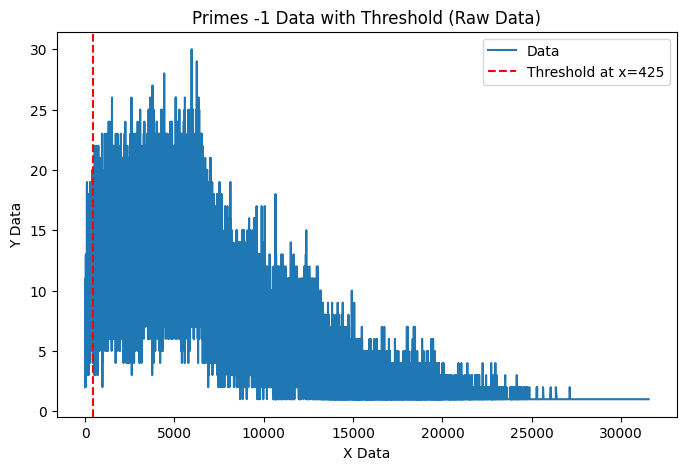

Best sigma for Twins: 9, Calculated Threshold: 344


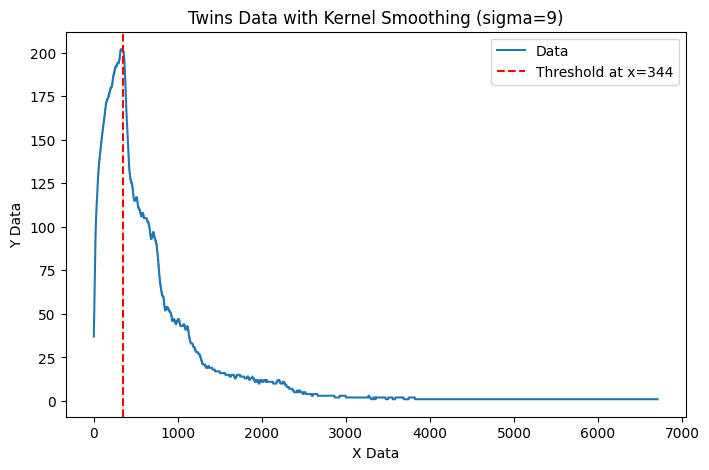

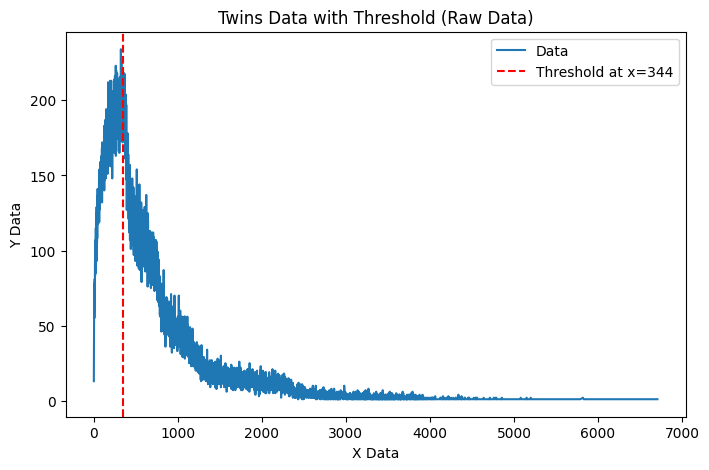

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def smooth_data_kernel(x_data, y_data, sigma=5):
    """
    Smooth data using a Gaussian kernel.
    'sigma' controls the width of the kernel.
    """
    # Ensure x_data and y_data are numpy arrays
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    # Sort the data by x_data
    sorted_indices = np.argsort(x_data)
    x_data_sorted = x_data[sorted_indices]
    y_data_sorted = y_data[sorted_indices]
    
    # Apply Gaussian smoothing to the sorted y_data
    smoothed_y = gaussian_filter1d(y_data_sorted, sigma, mode='nearest')  # 'nearest' handles edge effects well
    
    return x_data_sorted, smoothed_y


def find_threshold(x_data, y_data):
    """
    Find the threshold where the first derivative becomes negative (decreasing).
    """
    first_derivative = np.diff(y_data)
    decreasing_indices = np.where(first_derivative < 0)[0]
    if len(decreasing_indices) == 0:
        return x_data[-1]  # Return max if no threshold is found
    return x_data[decreasing_indices[0]]

def plot_data_with_threshold(x_data, y_data, threshold, title):
    """
    Plot the data and mark the threshold point.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(x_data, y_data, label="Data")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold at x={threshold}")
    plt.legend()
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title(title)
    plt.show()

def find_best_sigma(x_data, y_data, min_sigma=2, max_sigma=20):
    """
    Find the best sigma value by maximizing the detected threshold.
    Iterate over a range of sigma values
    """
    best_sigma, best_threshold = None, 0
    for sigma in range(min_sigma, max_sigma + 1):
        smoothed_x, smoothed_y = smooth_data_kernel(x_data, y_data, sigma)
        threshold = find_threshold(smoothed_x, smoothed_y)
        if threshold > best_threshold:
            best_threshold = threshold
            best_sigma = sigma
    return best_sigma, best_threshold


# Load data
datatxt_all = pd.read_csv('primes_data_150000.txt', low_memory=False)

for column in ['Primes +1', 'Primes -1', 'Twins']:
    data_counts = datatxt_all[column].value_counts().sort_index()
    x_data = data_counts.index.to_numpy()
    y_data = data_counts.values

    best_sigma, threshold = find_best_sigma(x_data, y_data)
    print(f"Best sigma for {column}: {best_sigma}, Calculated Threshold: {threshold}")

    smoothed_x, smoothed_y = smooth_data_kernel(x_data, y_data, sigma=best_sigma)
    plot_data_with_threshold(smoothed_x, smoothed_y, threshold, f"{column} Data with Kernel Smoothing (sigma={best_sigma})")
    plot_data_with_threshold(x_data, y_data, threshold, f"{column} Data with Threshold (Raw Data)")

Best divid for Primes +1: 72, Calculated Threshold: 6293.5


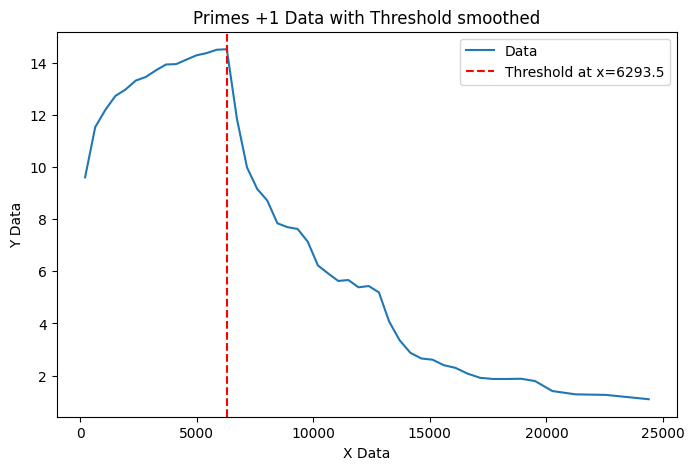

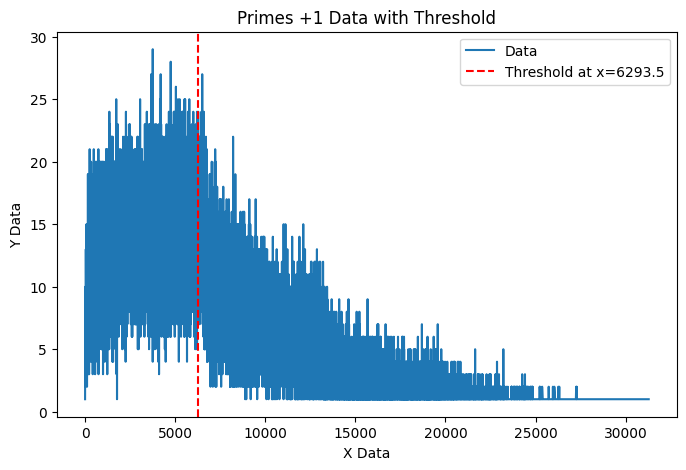

Best divid for Primes -1: 77, Calculated Threshold: 6340.0


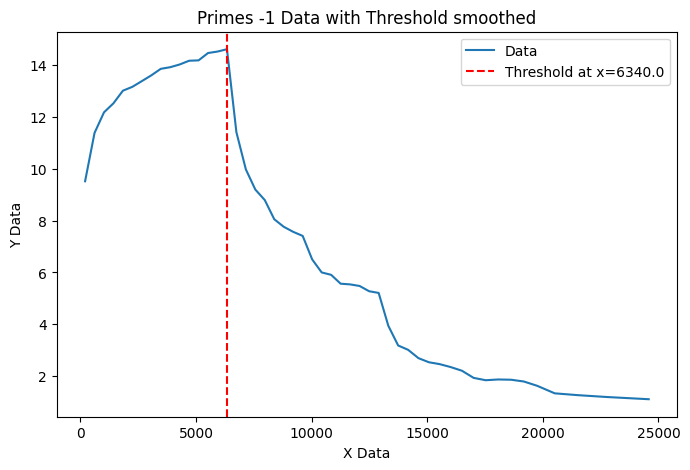

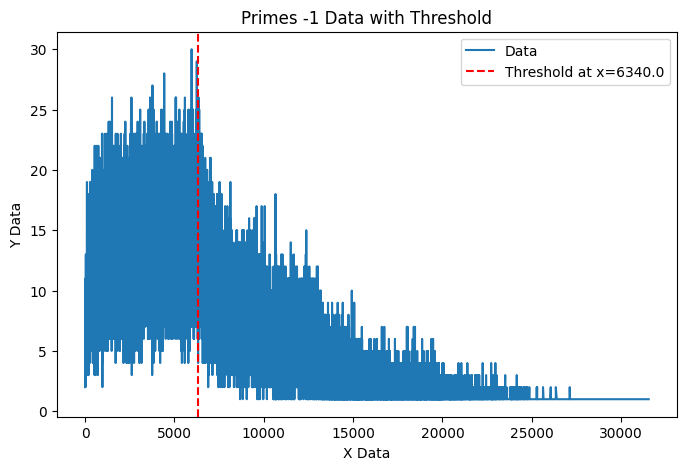

Best divid for Twins: 25, Calculated Threshold: 401.5


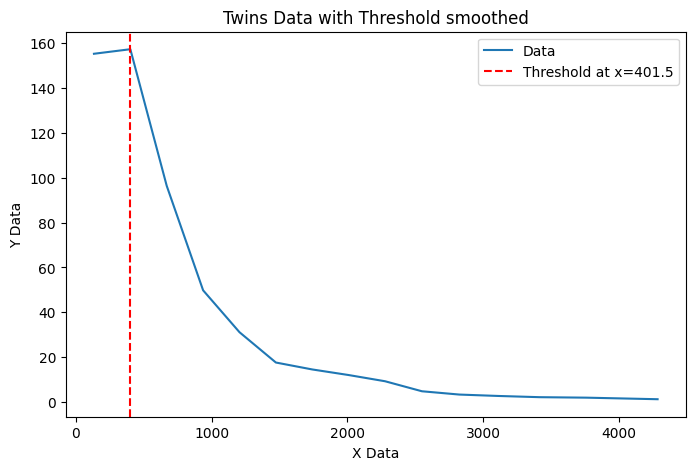

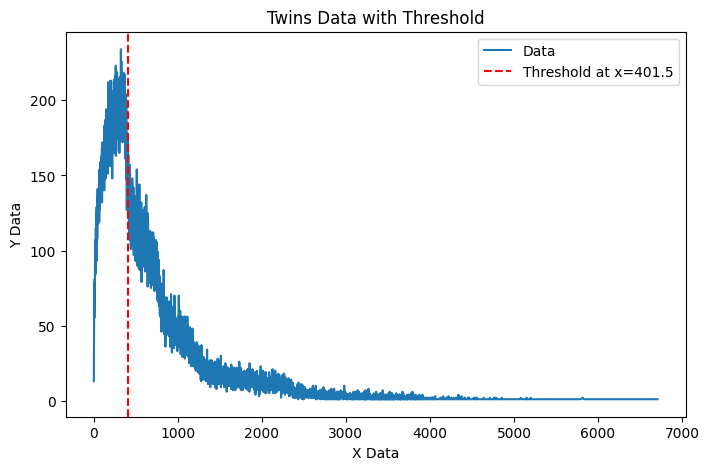

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def smooth_data(x_data, y_data, group_size):
    """
    Group data into intervals and calculate the mean of each group.
    """
    num_groups = max(1, len(x_data) // group_size)  # Ensure at least one group
    smoothed_x, smoothed_y = [], []
    
    for i in range(num_groups):
        group_x = x_data[i * group_size: (i + 1) * group_size]
        group_y = y_data[i * group_size: (i + 1) * group_size]
        if len(group_x) > 0:  # Avoid empty groups
            smoothed_x.append(np.mean(group_x))
            smoothed_y.append(np.mean(group_y))
    
    return np.array(smoothed_x), np.array(smoothed_y)

def find_threshold(x_data, y_data):
    """
    Find the threshold where the first derivative becomes negative (decreasing).
    """
    first_derivative = np.diff(y_data)
    decreasing_indices = np.where(first_derivative < 0)[0]
    if len(decreasing_indices) == 0:
        return x_data[-1]  # Return max if no threshold is found
    return x_data[decreasing_indices[0]]

def plot_data_with_threshold(x_data, y_data, threshold, title):
    """
    Plot the data and mark the threshold point.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(x_data, y_data, label="Data")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold at x={threshold}")
    plt.legend()
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title(title)
    plt.show()

def find_best_divid(x_data, y_data, min_divid=10, max_divid=100):
    """
    Find the best divide value by maximizing the detected threshold.
    """
    best_divid, best_threshold = None, 0
    for divid in range(min_divid, max_divid + 1):
        group_size = max(1, x_data[-1] // divid)
        smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size)
        threshold = find_threshold(smoothed_x, smoothed_y)
        if threshold > best_threshold:
            best_threshold = threshold
            best_divid = divid
    return best_divid, best_threshold

# Load data
datatxt_all = pd.read_csv('primes_data_150000.txt', low_memory=False)

for column in ['Primes +1', 'Primes -1', 'Twins']:
    data_counts = datatxt_all[column].value_counts().sort_index()
    x_data = data_counts.index.to_numpy()
    y_data = data_counts.values
    
    best_divid, threshold = find_best_divid(x_data, y_data)
    print(f"Best divid for {column}: {best_divid}, Calculated Threshold: {threshold}")
    
    group_size = max(1, x_data[-1] // best_divid)
    smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size)
    plot_data_with_threshold(smoothed_x, smoothed_y, threshold, f"{column} Data with Threshold smoothed")
    plot_data_with_threshold(x_data, y_data, threshold, f"{column} Data with Threshold")


Best divid for Primes +1: 12, Calculated Threshold: 70.5


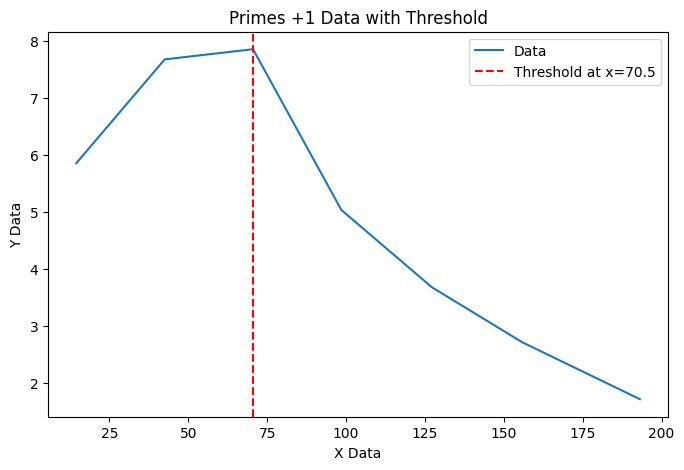

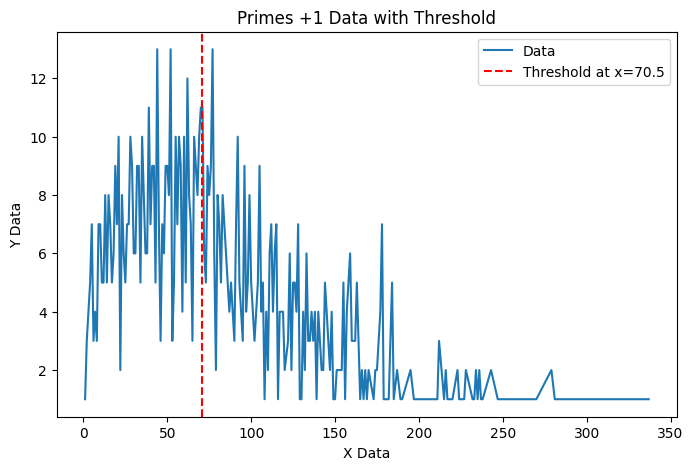

Best divid for Primes -1: 27, Calculated Threshold: 72.0


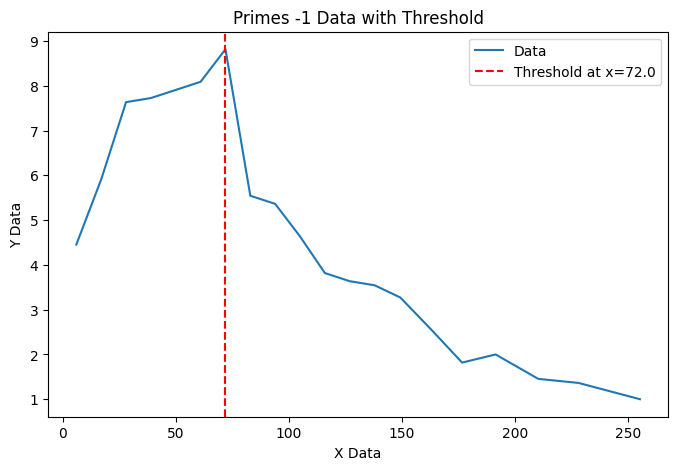

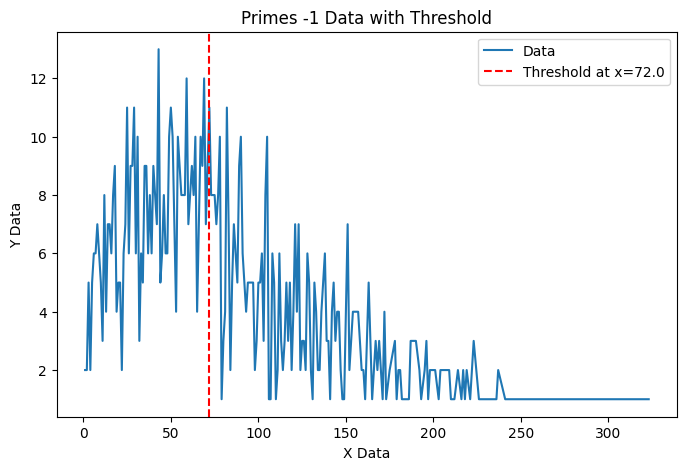

Best divid for Twins: 15, Calculated Threshold: 8.5


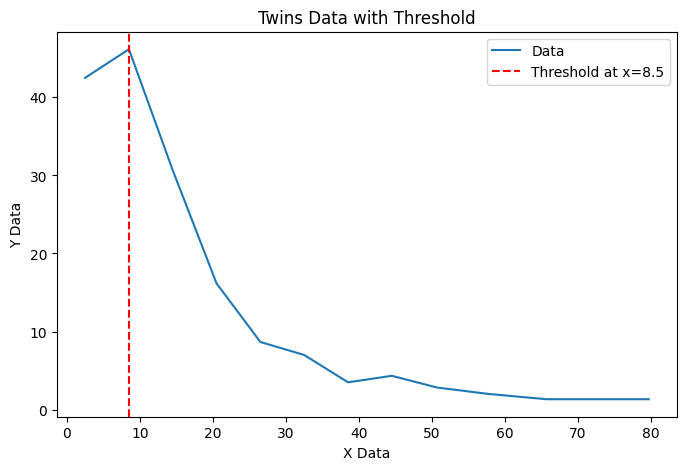

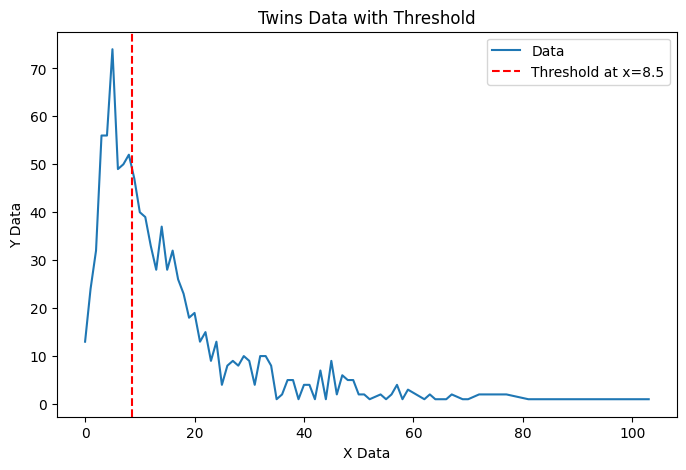

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def smooth_data(x_data, y_data, group_size):
    """
    Group data into intervals and calculate the mean of each group.
    """
    num_groups = max(1, len(x_data) // group_size)  # Ensure at least one group
    smoothed_x, smoothed_y = [], []
    
    for i in range(num_groups):
        group_x = x_data[i * group_size: (i + 1) * group_size]
        group_y = y_data[i * group_size: (i + 1) * group_size]
        if len(group_x) > 0:  # Avoid empty groups
            smoothed_x.append(np.mean(group_x))
            smoothed_y.append(np.mean(group_y))
    
    return np.array(smoothed_x), np.array(smoothed_y)

def find_threshold(x_data, y_data):
    """
    Find the threshold where the first derivative becomes negative (decreasing).
    """
    first_derivative = np.diff(y_data)
    decreasing_indices = np.where(first_derivative < 0)[0]
    if len(decreasing_indices) == 0:
        return x_data[-1]  # Return max if no threshold is found
    return x_data[decreasing_indices[0]]

def plot_data_with_threshold(x_data, y_data, threshold, title):
    """
    Plot the data and mark the threshold point.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(x_data, y_data, label="Data")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold at x={threshold}")
    plt.legend()
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title(title)
    plt.show()

def find_best_divid(x_data, y_data, min_divid=10, max_divid=100):
    """
    Find the best divide value by maximizing the detected threshold.
    """
    best_divid, best_threshold = None, 0
    for divid in range(min_divid, max_divid + 1):
        group_size = max(1, x_data[-1] // divid)
        smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size)
        threshold = find_threshold(smoothed_x, smoothed_y)
        if threshold > best_threshold:
            best_threshold = threshold
            best_divid = divid
    return best_divid, best_threshold

# Load data
datatxt_all = pd.read_csv('primes_data_150000.txt',low_memory=False).iloc[:1000]

for column in ['Primes +1', 'Primes -1', 'Twins']:
    data_counts = datatxt_all[column].value_counts().sort_index()
    x_data = data_counts.index.to_numpy()
    y_data = data_counts.values
    
    best_divid, threshold = find_best_divid(x_data, y_data)
    print(f"Best divid for {column}: {best_divid}, Calculated Threshold: {threshold}")
    
    group_size = max(1, x_data[-1] // best_divid)
    smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size)
    plot_data_with_threshold(smoothed_x, smoothed_y, threshold, f"{column} Data with Threshold")
    plot_data_with_threshold(x_data, y_data, threshold, f"{column} Data with Threshold")


Best divid for Primes +1: 72, Calculated Threshold: 6293.5


/tmp/ipykernel_1965428/572227152.py:59: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  datatxt_all = pd.read_csv('primes_data_150000.txt')


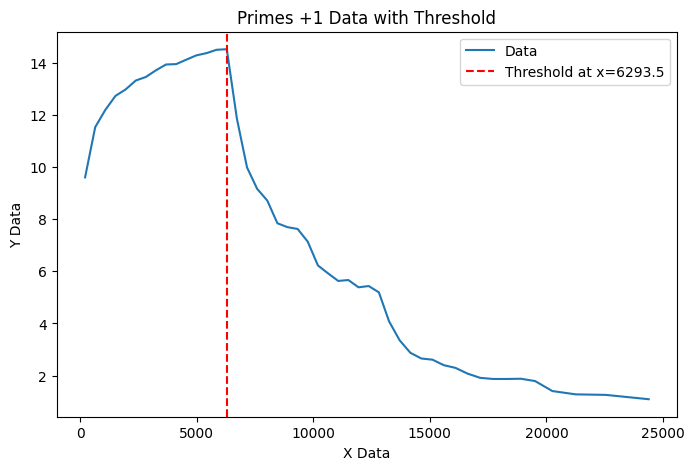

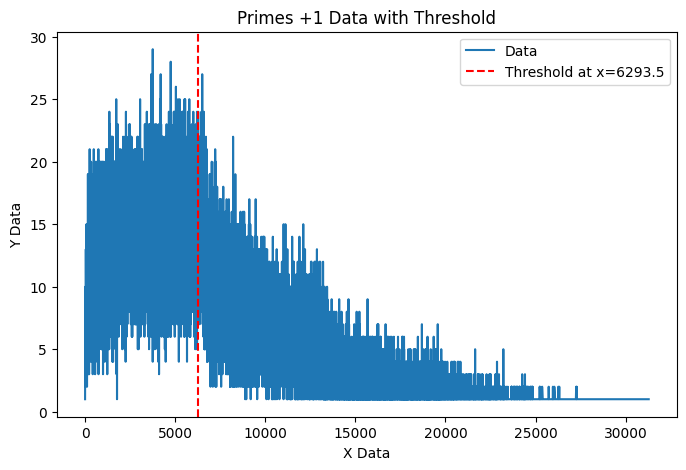

Best divid for Primes -1: 77, Calculated Threshold: 6340.0


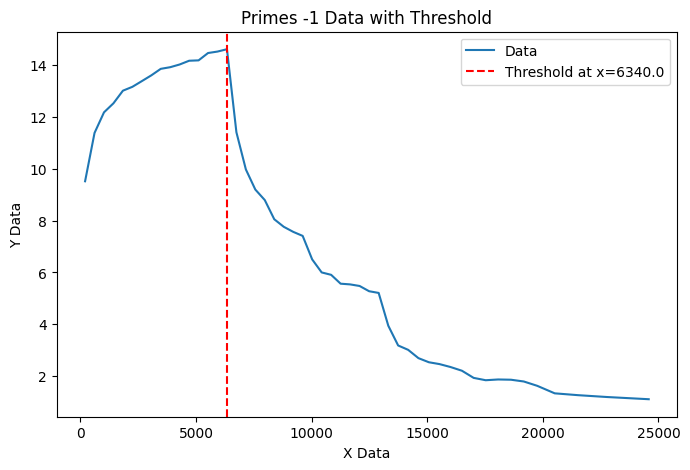

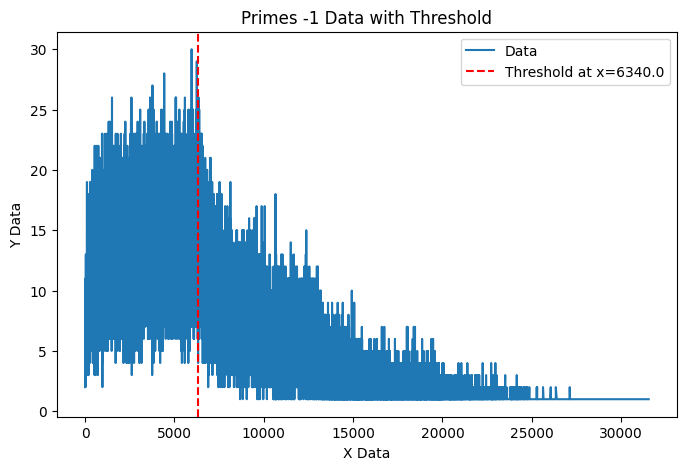

Best divid for Twins: 25, Calculated Threshold: 401.5


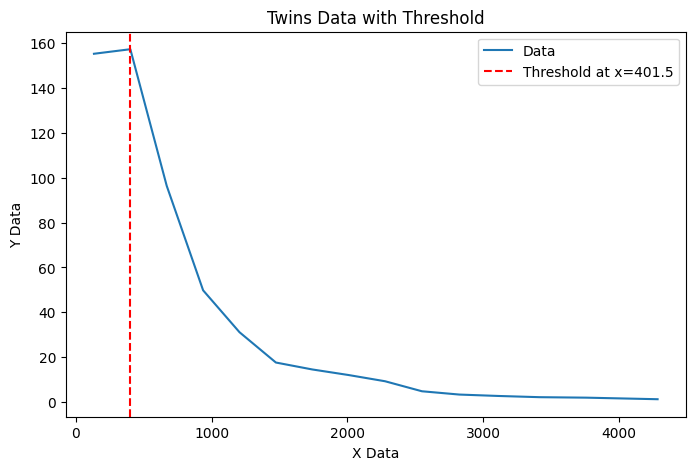

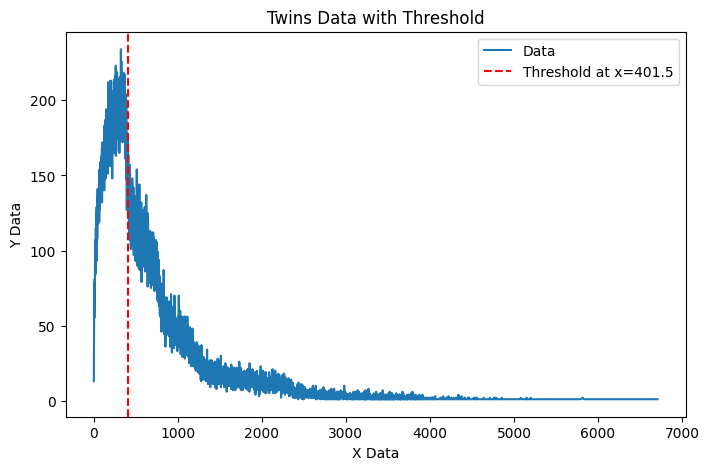

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def smooth_data(x_data, y_data, group_size):
    """
    Group data into intervals and calculate the mean of each group.
    """
    num_groups = max(1, len(x_data) // group_size)  # Ensure at least one group
    smoothed_x, smoothed_y = [], []
    
    for i in range(num_groups):
        group_x = x_data[i * group_size: (i + 1) * group_size]
        group_y = y_data[i * group_size: (i + 1) * group_size]
        if len(group_x) > 0:  # Avoid empty groups
            smoothed_x.append(np.mean(group_x))
            smoothed_y.append(np.mean(group_y))
    
    return np.array(smoothed_x), np.array(smoothed_y)

def find_threshold(x_data, y_data):
    """
    Find the threshold where the first derivative becomes negative (decreasing).
    """
    first_derivative = np.diff(y_data)
    decreasing_indices = np.where(first_derivative < 0)[0]
    if len(decreasing_indices) == 0:
        return x_data[-1]  # Return max if no threshold is found
    return x_data[decreasing_indices[0]]

def plot_data_with_threshold(x_data, y_data, threshold, title):
    """
    Plot the data and mark the threshold point.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(x_data, y_data, label="Data")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold at x={threshold}")
    plt.legend()
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title(title)
    plt.show()

def find_best_divid(x_data, y_data, min_divid=10, max_divid=100):
    """
    Find the best divide value by maximizing the detected threshold.
    """
    best_divid, best_threshold = None, 0
    for divid in range(min_divid, max_divid + 1):
        group_size = max(1, x_data[-1] // divid)
        smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size)
        threshold = find_threshold(smoothed_x, smoothed_y)
        if threshold > best_threshold:
            best_threshold = threshold
            best_divid = divid
    return best_divid, best_threshold

# Load data
datatxt_all = pd.read_csv('primes_data_150000.txt')

for column in ['Primes +1', 'Primes -1', 'Twins']:
    data_counts = datatxt_all[column].value_counts().sort_index()
    x_data = data_counts.index.to_numpy()
    y_data = data_counts.values
    
    best_divid, threshold = find_best_divid(x_data, y_data)
    print(f"Best divid for {column}: {best_divid}, Calculated Threshold: {threshold}")
    
    group_size = max(1, x_data[-1] // best_divid)
    smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size)
    plot_data_with_threshold(smoothed_x, smoothed_y, threshold, f"{column} Data with Threshold")
    plot_data_with_threshold(x_data, y_data, threshold, f"{column} Data with Threshold")



Processing dataset: Primes +1
Original max x = 31278
Calculated Threshold for Primes +1: 6195.5


/tmp/ipykernel_1965428/146124787.py:87: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  datatxt_all = pd.read_csv('primes_data_150000.txt')


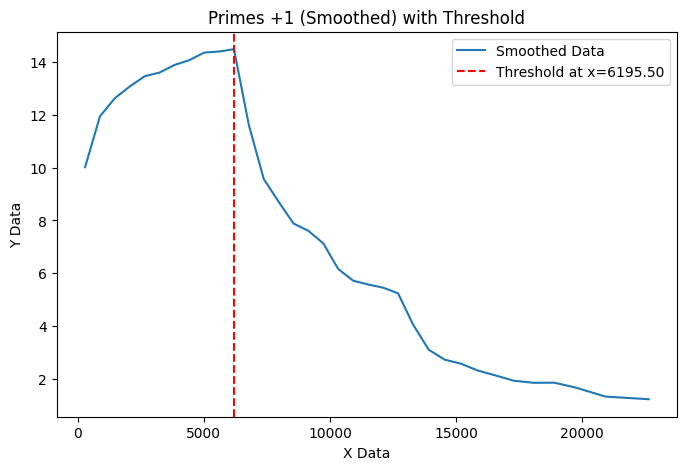

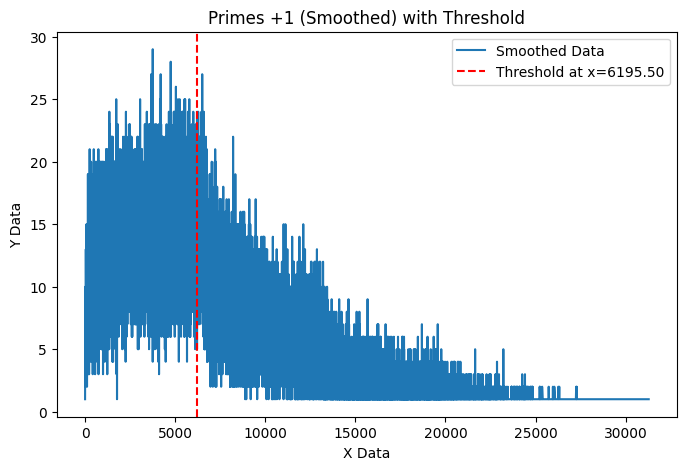


Processing dataset: Primes -1
Original max x = 31543
Calculated Threshold for Primes -1: 6248.0


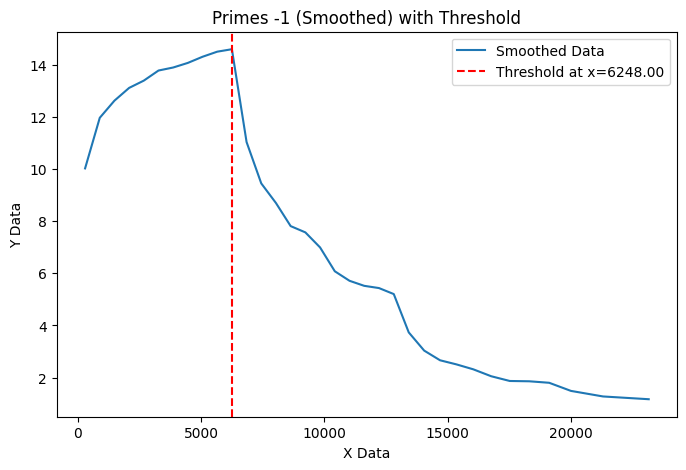

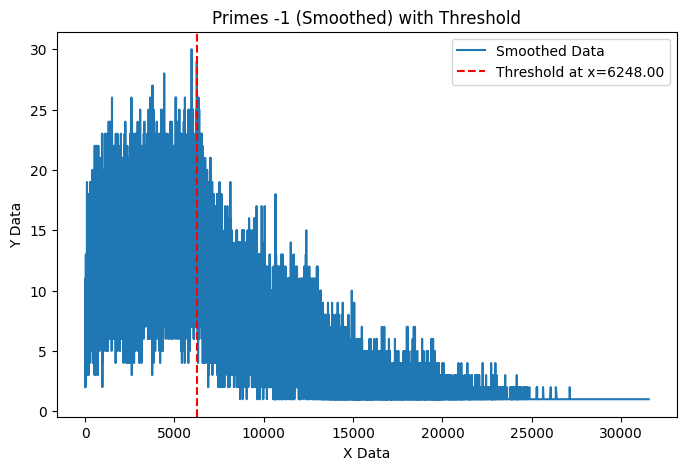


Processing dataset: Twins
Original max x = 6708
Calculated Threshold for Twins: 314.5


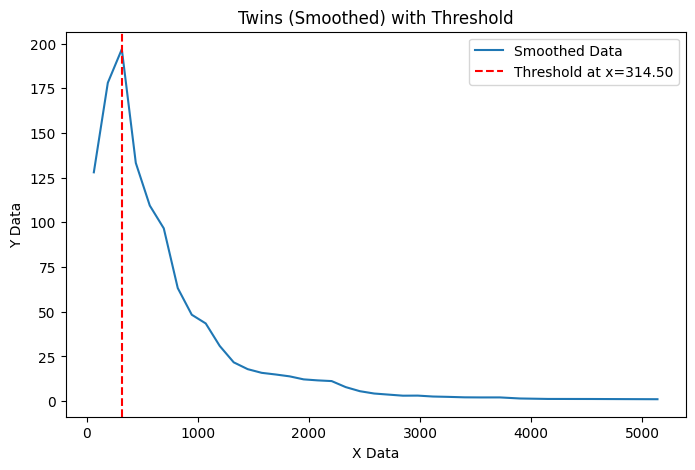

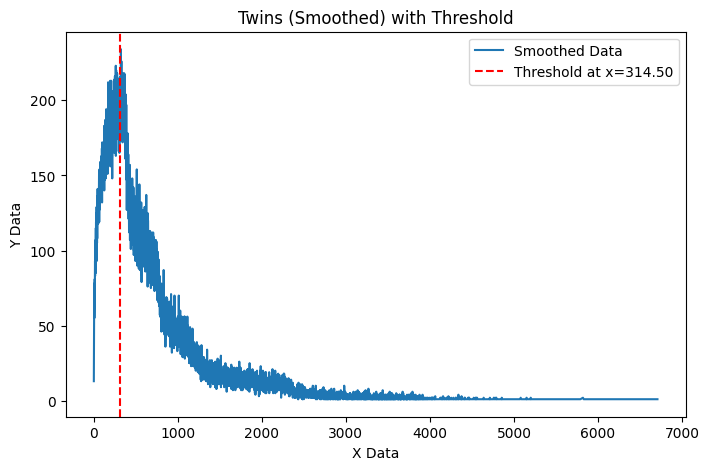

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def smooth_data(x_data, y_data, group_size):
    """
    Smooths the data by partitioning the x and y arrays into groups 
    of length `group_size` and computing the mean within each group.
    
    Parameters:
        x_data (array-like): The x-values (assumed sorted in ascending order).
        y_data (array-like): The y-values.
        group_size (int): The number of data points to include in each group.
    
    Returns:
        tuple: (smoothed_x, smoothed_y) as numpy arrays containing the group means.
    """
    num_groups = len(x_data) // group_size  # Only full groups are considered
    smoothed_x = []
    smoothed_y = []
    
    for i in range(num_groups):
        # Slice out the current group for both x and y values.
        group_x = x_data[i * group_size: (i + 1) * group_size]
        group_y = y_data[i * group_size: (i + 1) * group_size]
        
        # Compute the mean of the group.
        smoothed_x.append(np.mean(group_x))
        smoothed_y.append(np.mean(group_y))
    
    return np.array(smoothed_x), np.array(smoothed_y)

def find_threshold(smoothed_x, smoothed_y):
    """
    Finds the threshold in the smoothed data as the first x-value at which
    the first derivative (estimated via finite differences) becomes negative.
    
    Parameters:
        smoothed_x (array-like): The smoothed x-values.
        smoothed_y (array-like): The smoothed y-values.
    
    Returns:
        float: The x-value at which the smoothed data first begins to decrease.
               If the data never decreases, the maximum smoothed x is returned.
    """
    # Compute finite differences.
    dx = np.diff(smoothed_x)
    dy = np.diff(smoothed_y)
    
    # Avoid division by zero issues.
    with np.errstate(divide='ignore', invalid='ignore'):
        derivative = np.where(dx != 0, dy / dx, 0)
    
    # Identify the first index where the derivative is negative.
    negative_indices = np.where(derivative < 0)[0]
    
    if negative_indices.size > 0:
        threshold_index = negative_indices[0]
        threshold = smoothed_x[threshold_index]
    else:
        threshold = smoothed_x[-1]
    
    return threshold

def plot_data(smoothed_x, smoothed_y, threshold, title="Smoothed Data with Threshold"):
    """
    Plots the smoothed data and marks the computed threshold with a vertical dashed red line.
    
    Parameters:
        smoothed_x (array-like): The smoothed x-values.
        smoothed_y (array-like): The smoothed y-values.
        threshold (float): The threshold x-value to highlight.
        title (str): The title for the plot.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(smoothed_x, smoothed_y, label="Smoothed Data")
    plt.axvline(x=threshold, color='red', linestyle='--', label=f"Threshold at x={threshold:.2f}")
    plt.xlabel("X Data")
    plt.ylabel("Y Data")
    plt.title(title)
    plt.legend()
    plt.show()

# ------------------- Main Script -------------------

# Read the data from the CSV file.
datatxt_all = pd.read_csv('primes_data_150000.txt')

# Compute value counts (sorted by the number itself) for each of the three datasets.
number_counts_primes_plus_one = datatxt_all['Primes +1'].value_counts().sort_index()
number_counts_primes_minus_one = datatxt_all['Primes -1'].value_counts().sort_index()
number_counts_primes_twins = datatxt_all['Twins'].value_counts().sort_index()

# You can adjust this divider parameter to control the group size.
divid = 53

# Store the three datasets in a dictionary for processing.
datasets = {
    "Primes +1": number_counts_primes_plus_one,
    "Primes -1": number_counts_primes_minus_one,
    "Twins": number_counts_primes_twins
}

# Process each dataset independently.
for label, data in datasets.items():
    # Convert the index (unique numbers) and their counts to numpy arrays.
    x_data = data.index.to_numpy()
    y_data = data.values
    
    print(f"\nProcessing dataset: {label}")
    print("Original max x =", x_data[-1])
    
    # Define the group size based on the maximum x value and the divider.
    # This follows the heuristic: group_size = max(x_data) // divid.
    max_x = int(x_data[-1])
    group_size = max_x // divid
    if group_size < 1:
        group_size = 1  # Ensure at least one data point per group.
    
    # Smooth the data.
    smoothed_x, smoothed_y = smooth_data(x_data, y_data, group_size=group_size)
    
    # Find the threshold in the smoothed data.
    threshold = find_threshold(smoothed_x, smoothed_y)
    print(f"Calculated Threshold for {label}: {threshold}")
    
    # Plot the smoothed data with the threshold indicated.
    plot_data(smoothed_x, smoothed_y, threshold, title=f"{label} (Smoothed) with Threshold")
    plot_data(x_data, y_data, threshold, title=f"{label} (Smoothed) with Threshold")
